# Aprendizaje Autosupervisado

In [1]:
from itertools import islice as take
from random import randint

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
from skimage import io
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from tqdm import tqdm
from PIL import Image

# CIFAR-10
MEAN = (0.4914, 0.4822, 0.4465)
STD = (0.2023, 0.1994, 0.2010)
LABELS = (
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Datos

#### Exploración

In [2]:
# creamos un Dataset
ds = CIFAR10(root='./data', train=True, transform=np.array, download=True)
# creamos un DataLoader
dl = DataLoader(ds, batch_size=12)

Files already downloaded and verified


x shape=torch.Size([12, 32, 32, 3]) dtype=torch.uint8
y shape=torch.Size([12]) dtype=torch.int64
tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7])
['frog', 'truck', 'truck', 'deer', 'automobile', 'automobile', 'bird', 'horse', 'ship', 'cat', 'deer', 'horse']


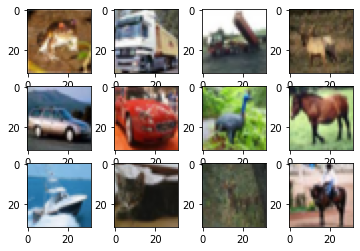

In [3]:
# desplegamos un lote de imágenes
for x, y in take(dl, 1):
    # imprimimos la forma y tipo de los tensores
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')
    # desplegamos imagenes
    io.imshow_collection(x)
    # imprimimos etiquetas
    print(y)
    print([LABELS[l] for l in y])

In [4]:
class CIFAR10Rot(CIFAR10):
    
    def random_rotate(self, x):
        r = randint(0, 4)
        if r == 0:
            return x, 0
        elif r == 1:
            return np.flipud(np.transpose(x, (1, 0, 2))), 1
        elif r == 2:
            return np.flipud(np.fliplr(x)), 2
        else:
            return np.fliplr(np.transpose(x, (1, 0, 2))), 3
    
    def __getitem__(self, index):
        # leemos la imagen
        img = self.data[index]
        # la rotamos
        img, target = self.random_rotate(img)
        # la convertimos a pillow
        img = Image.fromarray(img)
        # aplicamos transformación si es necesario
        if self.transform is not None:
            img = self.transform(img)
        
        return img, target

In [5]:
# creamos un Dataset
ds = CIFAR10Rot(root='./data', train=True, transform=np.array, download=True)
# creamos un DataLoader
dl = DataLoader(ds, batch_size=12)

Files already downloaded and verified


x shape=torch.Size([12, 32, 32, 3]) dtype=torch.uint8
y shape=torch.Size([12]) dtype=torch.int64


<Figure size 720x720 with 0 Axes>

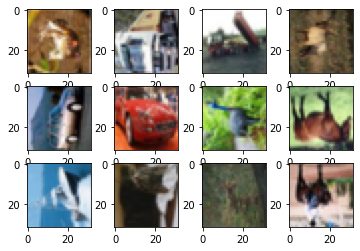

tensor([3, 1, 0, 3, 1, 0, 1, 2, 1, 3, 0, 2])
tensor([270,  90,   0, 270,  90,   0,  90, 180,  90, 270,   0, 180])


In [19]:
# desplegamos un lote de imágenes
for x, y in take(dl, 1):
    # imprimimos la forma y tipo de los tensores
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')
    # desplegamos imagenes
    plt.figure(figsize=(10,10))
    io.imshow_collection(x)
    plt.show()
    # imprimimos etiquetas
    print(y)
    print(y * 90)

#### Cargadores de entrenamiento

In [7]:
trn_tsfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])
trn_ds = CIFAR10Rot(root='./data', train=True,
                 transform=trn_tsfm)

# creamos un DataLoader
trn_dl = DataLoader(trn_ds, batch_size=128, shuffle=True)

# desplegamos un lote de imágenes
for x, y in take(trn_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


#### Cargadores de validación

In [8]:
# transformaciones para la imagén
val_tsfm = transforms.Compose([
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    transforms.Normalize(MEAN, STD),
])

# creamos un Dataset
val_ds = CIFAR10Rot(
    # ruta para leerlos datos
    root='./data', 
    # subconjunto de entrenamiento
    train=False,
    # tranformación
    transform=val_tsfm
)

# creamos un DataLoader
val_dl = DataLoader(
    # Dataset
    val_ds,
    # tamaño del lote
    batch_size=128
)

# imprimimos forma y tipo del lote
for x, y in take(val_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


### Modelo

In [9]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.num_feats = 3 * 32 * 32
        self.fc1 = nn.Linear(self.num_feats, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, self.num_feats)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [10]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        C1, C2, C3 = 8, 16, 32
        self.num_feats = 32 * 4 * 4
        # capas convolucionales
        self.conv1 = nn.Conv2d(3, C1, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(C1)
        self.conv2 = nn.Conv2d(C1, C2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(C2)
        self.conv3 = nn.Conv2d(C2, C3, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(C3)
        # capa de clasificación
        self.fc = nn.Linear(self.num_feats, 10)

    def forward(self, x):
        
        # [N, 3, 32, 32] => [N, 8, 32, 32]
        x = self.conv1(x)
        # [N, 8, 30, 30]
        x = self.bn1(x)
        x = F.relu(x)
        # [N, 8, 30, 30] => [N, 8, 16, 16]
        x = F.max_pool2d(x, 2)

        # [N, 8, 16, 16] => [N, 16, 16, 16]
        x = self.conv2(x)
        # [N, 16, 16, 16]
        x = self.bn2(x)
        x = F.relu(x)
        # [N, 16, 16, 16] => [N, 16, 8, 8]
        x = F.max_pool2d(x, 2)

        # [N, 16, 8, 8] => [N, 32, 8, 8]
        x = self.conv3(x)
        # [N, 32, 8, 8]
        x = self.bn3(x)
        x = F.relu(x)
        # [N, 32, 8, 8] => [N, 32, 4, 4]
        x = F.max_pool2d(x, 2)

        # [N, 32, 4, 4] => [N, 32x4x4]
        x = x.view(-1, self.num_feats)
        # [N, 32x4x4] => [N, 10]
        x = self.fc(x)

        return x

### Entrenamiento

In [11]:
# creamos un modelo
model = CNN()
# función de pérdida
loss_fn = nn.CrossEntropyLoss()
# optimizador
opt = optim.Adam(model.parameters(), lr=0.001)

# ciclo de entrenamiento
EPOCHS = 10
for epoch in range(EPOCHS):
    
    # entrenamiento de una época
    for x, y_true in trn_dl:
        # vaciamos los gradientes
        opt.zero_grad()
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad(): 
        # modelo en modo de evaluación
        model.eval()
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in val_dl:
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos en históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # imprimimos métricas
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100
        print(f'E {epoch} loss={loss:.2f} acc={acc:.2f}')
        
        # modelo en modo de entrenamiento
        model.train()

E 0 loss=98.62 acc=59.77
E 1 loss=96.29 acc=61.95
E 2 loss=89.53 acc=64.46
E 3 loss=92.93 acc=62.80
E 4 loss=84.48 acc=65.96
E 5 loss=82.24 acc=67.99
E 6 loss=81.33 acc=67.65
E 7 loss=80.76 acc=67.99
E 8 loss=79.74 acc=68.36
E 9 loss=80.92 acc=67.92
